In [31]:
import math
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import json
from datetime import datetime
import time
import numpy as np
from ast import literal_eval as make_tuple

# lowest point that can potentially be reached (caspian depression, kazakhstan)
min_alt = -138


def set_map_size(my_dpi):
    '''creates the map in the background. allows to determine dpi of the map'''
    plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

    
def create_map():
    '''creates the map'''
    m = Basemap(projection='mill',llcrnrlat=25.1,urcrnrlat=71.5,\
            llcrnrlon=-10.5,urcrnrlon=87.3,resolution='i')
    
    m.shadedrelief()
    m.drawcountries()
    m.fillcontinents(color='#04BAE3', lake_color='#FFFFFF', zorder=0)
    m.drawmapboundary(fill_color='#FFFFFF')
    
    return m


def prepare_location_history(json_file):
    '''takes any google location history and formats it so its data points can be evaluated'''
    with open(json_file) as f:
        info = f.read()
    info = json.loads(info)
    
    try:
        info = info["locations"] 
    except:
        pass
    
    return info


def check_json_file(info):
    '''provides information about the json file used'''
    print("about to plot %s data points..." %len(info))
    timestamps = [d['timestampMs'] for d in info]
    print("the oldest timestamp is from:", datetime.fromtimestamp(int(min(timestamps)) / 1000))
    print("the newest timestamp is from:", datetime.fromtimestamp(int(max(timestamps)) / 1000))

    
def plot_points(m, info, colorcode_list):
    lons = []
    lats = []
    
    for point in info:
        if not "altitude" in point:
            continue
        x, y = m(point['longitudeE7'] / 10**7,point['latitudeE7'] / 10**7)
        lons.append(x)
        lats.append(y)
    
    plt.scatter(lons, lats, c=colorcode_list, alpha=1.0, zorder=2)
    plt.plot(lons, lats, color='#fee5d9', marker='o', markersize=3, zorder=1)
    plt.title('Europe & parts of Asia, May to November 2018')
    
    return plt.show()


def find_extreme_altitudes(info):
    '''creates list with extreme altitude points from info'''
    newalts = []
    for entry in info:
        if "altitude" in entry:
            if entry["altitude"] <= min_alt:
                newalts.append(0)
            else:
                newalts.append(entry["altitude"])
        else:
            newalts.append(0)
    newalts.sort()
    return newalts[:10], newalts[len(newalts) - 10:] # returns one list containing two lists - mins and maxs

In [32]:
def find_range_of_alts(info):
    '''returns the range in which the points move altitude-wise. allows to distribute altitude colors evenly'''
    minsmaxs = find_extreme_altitudes(info)
    mini = minsmaxs[0][0]
    maxi = minsmaxs[-1][-1]
    return abs(mini) + maxi


def find_point_color(altitude, change_color_after):
    '''returns the colorcode for each altitude. these can be inserdes in g and b'''
    if altitude == 0:
        return 1
    
    times_11 = abs(altitude + mini) / change_color_after
    colorcode = 255 - times_11
    
    return colorcode


def create_colorcodes_by_altitude(info):
    '''returns list colorcodes (g (and b))'''
    colorcode_list = []
    
    for point in info:    
        
        if not "altitude" in point:
            continue
        
        color = find_point_color(point["altitude"], change_color_after)
        colorcode_list.append(color)
        
    return colorcode_list


def make_rgb_code(colorcode_list):
    final_colorcodes = []
    
    for i in colorcode_list:
        new = make_tuple("({}, {}, {})".format(1.0, i / 255.0, i / 255.0))
        final_colorcodes.append(new)
        
    return final_colorcodes

In [33]:
info = prepare_location_history("Standortverlauf_m_iran.json")
check_json_file(info)

about to plot 334259 data points...
the oldest timestamp is from: 2018-06-02 15:08:47.319000
the newest timestamp is from: 2018-10-27 09:23:30.073000


In [36]:
def prepare_plot_coloring(info):
    '''returns list of tuples containing rgb codes that allow to color the points depending on altitude.
    needs to be improved, especially made more readable and logical.'''
    range_of_alts = find_range_of_alts(info)
    rgb_max = 255
    
    change_color_after = range_of_alts / rgb_max
    mini = find_extreme_altitudes(info)[0][0]
    
    colorcodes = create_colorcodes_by_altitude(info)
    return make_rgb_code(colorcodes)

colorcode_list = prepare_plot_coloring(info)

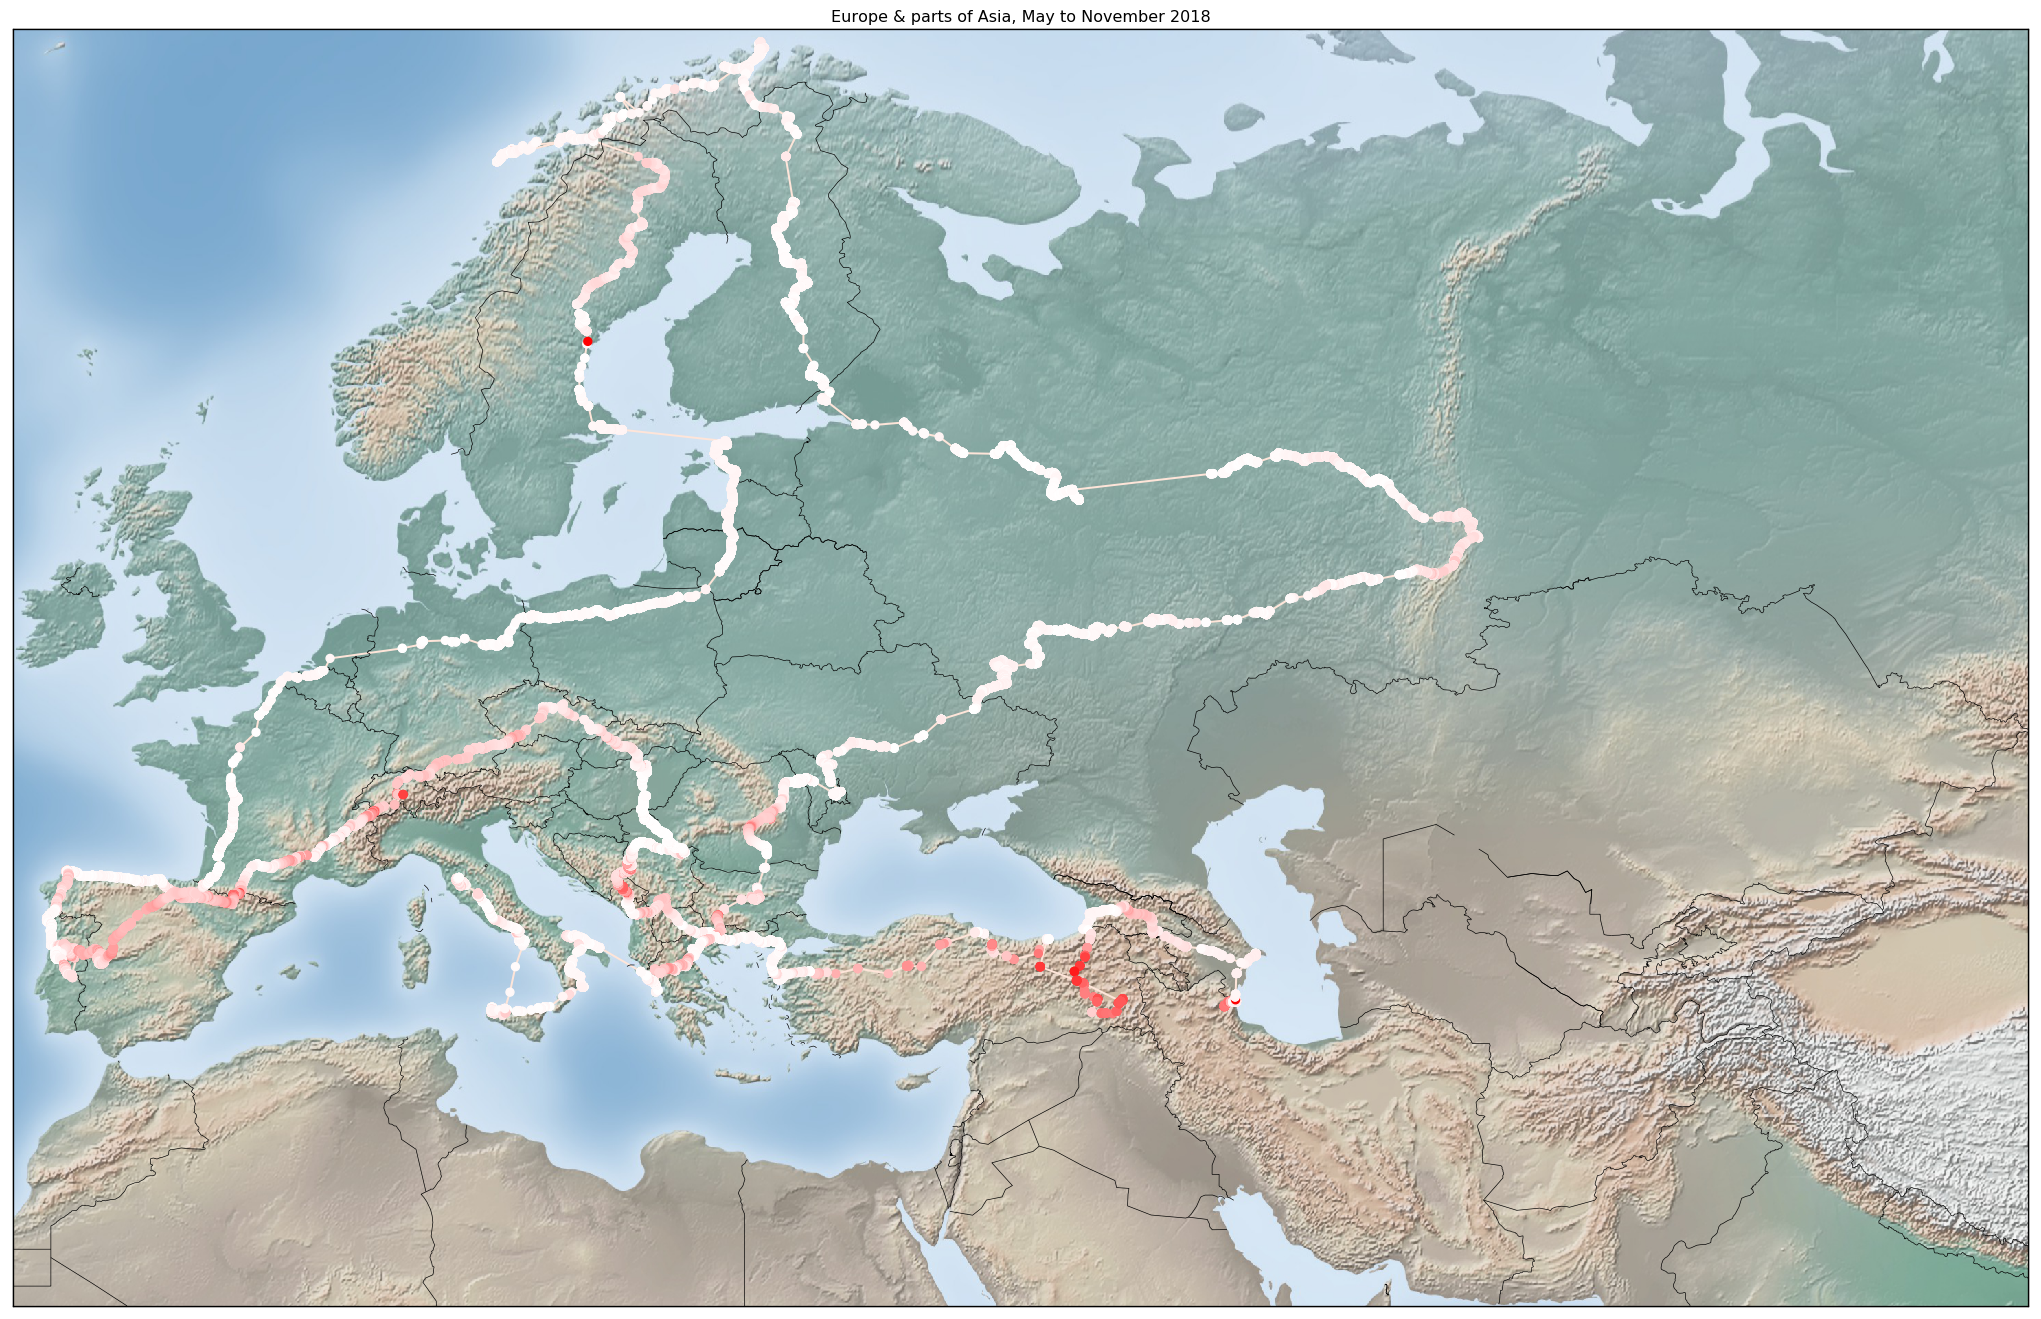

In [37]:
#drawing the map

set_map_size(96)
m = create_map()

plot_points(m, info, colorcode_list)

# SIMPLE GRAPH THAT SHOWS ALTITUDE OVER TIME

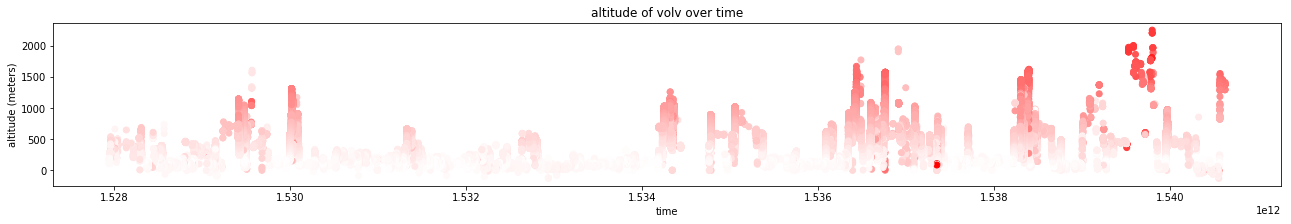

In [21]:
timestamps = np.array([int(d['timestampMs']) for d in info if "altitude" in d if d['altitude'] > min_alt])
altitudes = np.array([d['altitude'] for d in info if "altitude" in d if d['altitude'] > min_alt]) # y-achse


fig, ax = plt.subplots()
fig.set_size_inches(22,3)

ax.set(xlabel='time', ylabel='altitude (meters)',
       title='altitude of volv over time')

plt.scatter(timestamps, altitudes, c=ha, alpha=1.0) # x, y

# (work in progress:) developing distance measurement in order to eliminate outliers

In [19]:
def degree_to_radian(deg):
    '''converts degree to radian coordinates'''
    return deg * (math.pi / 180.0)


def distance_a_b(lat_a, lon_a, lat_b, lon_b):
    '''returns the distance between two gps coordinates in km using haversine formula. needs degree_to_radian(deg) conversion'''
    er = 6371 # radius of the earth in km
    lat_distance = degree_to_radian(abs(lat_a - lat_b))
    lon_distance = degree_to_radian(abs(lon_a - lon_b))
    
    a = math.sin(lat_distance / 2) **2 + math.cos(degree_to_radian(lat_a) * math.cos(degree_to_radian(lat_b))) * math.sin(lon_distance/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return er * c

In [29]:
print("distance between kiev and ankara: google: 1.185,32 km (736,52 mi), measured:", distance_a_b(39.929392, 32.865392, 50.371005, 30.365041))
print("distance between dushanbe and pugus: google: 32,89 km (20,44 mi), measured:", distance_a_b(38.560658, 68.786172, 38.850752, 68.851342))
print("distance between almaty and porto: google: 6.711,00 km (4.170,02 mi), measured:", distance_a_b(43.237937, 76.851400, 41.160502, -8.629828))
# --> not exact yet for long distances!

distance between kiev and ankara: google: 1.185,32 km (736,52 mi), measured: 1190.8910815546185
distance between dushanbe and pugus: google: 32,89 km (20,44 mi), measured: 32.954158116149166
distance between almaty and porto: google: 6.711,00 km (4.170,02 mi), measured: 8575.728740228284
